Found 329 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 74969474 (285.99 MB)
Trainab

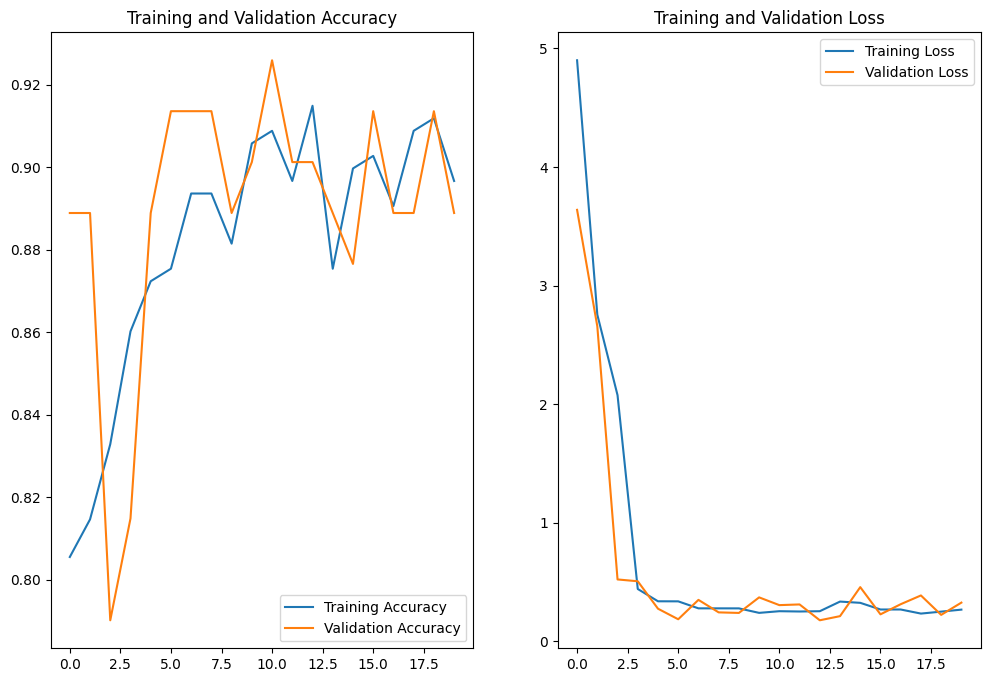

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Set the path to the dataset
data_dir = '/content/drive/MyDrive/Plant disease detection  Dataset'
batch_size = 32
img_height = 224
img_width = 224

# Create an ImageDataGenerator instance for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Number of classes (categories)
num_classes = len(train_generator.class_indices)

# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = False

# Define the custom top layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluate the model’s performance and visualize the training history
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [7]:
#hyperparameter tuning
def model_builder(hp):
    model = tf.keras.Sequential()

    # Tune the 'number of filters','kernel size' and 'activation function' for each Conv2D layer
    for i in range(5):
        hp_Numfilters = hp.Int(f'filters_{i}', min_value=32, max_value=256, step=32)
        hp_kernel_size = hp.Choice(f'kernel_size_{i}', values=[3, 5])
        hp_activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])

        if i == 0:
            model.add(layers.Conv2D(filters=hp_Numfilters, kernel_size=hp_kernel_size, activation=hp_activation, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))

        else:
            model.add(layers.Conv2D(filters=hp_Numfilters, kernel_size=hp_kernel_size, activation=hp_activation))


        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Tune the fully connected (Dense) layers
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)
    hp_dense_activation = hp.Choice('dense_activation', values=['relu', 'tanh'])

    model.add(layers.Dense(units=hp_dense_units, activation=hp_dense_activation))

    # output layer, since Binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Shape of images in batch: (32, 224, 224, 3)
Shape of labels in batch: (32, 2)


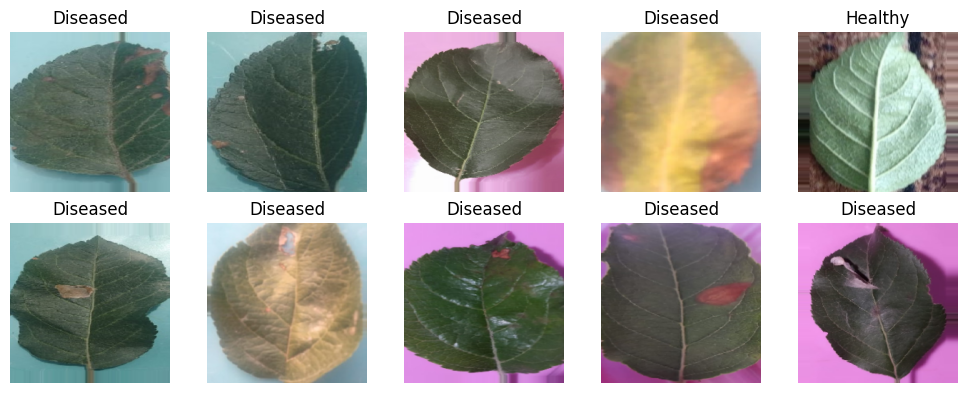

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve a batch of images and labels from the training generator
images, labels = next(train_generator)

# Print the shape of images and labels in the batch
print("Shape of images in batch:", images.shape)
print("Shape of labels in batch:", labels.shape)

# Plot a few images
plt.figure(figsize=(10, 4))
for i in range(10):  # Change the range to plot more/less images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    # Decode the label (one-hot encoding to class label)
    label = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label]
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Predict**

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an image for prediction
img_path = '/content/drive/MyDrive/Plant disease detection  Dataset/Diseased/1011.JPG.jpeg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the mapping
predicted_label = class_labels[predicted_class[0]]
print(f"Predicted class: {predicted_label}")


1/1 [==============================] - 2s 2s/step
Predicted class: Diseased


In [10]:
# Save the model
model.save('plant_disease_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
